In [26]:
# подключим нужные библиотеки, сразу зададим размер визуализаций

import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11,8)})

In [27]:
# подключимся к базе и сформируем нужный нам запрос: вытащим данные по 4 группам за период АB-теста 

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

q = '''
    SELECT exp_group, user_id, sum(if(action = 'view', 1, 0)) as views,
            sum(if(action = 'like', 1, 0)) as likes,
            likes/views as ctr
    from simulator_20220720.feed_actions
    where toDate(time) between '2022-06-13' and '2022-06-19' and exp_group in (0, 1, 2, 3)
    group by exp_group, user_id
    
    '''
    
df = pandahouse.read_clickhouse(q, connection=connection)

df.head()

,exp_group,user_id,views,likes,ctr
0,3,115383,30,9,0.300000
1,1,18392,32,7,0.218750
2,2,131473,134,14,0.104478
3,3,123580,48,13,0.270833
4,2,32420,128,26,0.203125


Группы 1 и 2

In [49]:
# создадим отдельный df и посчитаем общий ctr в контрольной sum(likes)/sum(views)
df_1 = df[(df['exp_group'] == 1) | (df['exp_group'] == 2)] 
ctr_control_1 = df_1[df_1['exp_group'] == 1]['likes'].sum()/ df_1[df_1['exp_group'] == 1]['views'].sum()
print(ctr_control_1)

0.20802680490126244


In [51]:
# считаме поюзерную метрику linearazied_likes

df_1['linearazied_likes'] = df_1['likes'] - ctr_control_1 * df_1['views']
df_1.head()

/tmp/ipykernel_115/1226529317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['linearazied_likes'] = df_1['likes'] - ctr_control_1 * df_1['views']


,exp_group,user_id,views,likes,ctr,linearazied_likes
1,1,18392,32,7,0.218750,0.343142
2,2,131473,134,14,0.104478,-13.875592
4,2,32420,128,26,0.203125,-0.627431
5,2,24239,90,40,0.444444,21.277588
7,1,27443,29,2,0.068966,-4.032777


Из предыдущего задания помним, что группы имеют статистически значимые отличия и при этом мы не пользовались t-тестом в связи с сильной ненормальностью тестовой группы. Посмотрим на результаты сравнения лин.лайков t-тестом и сравнения обычного ctr тем же t-тестом 

In [52]:
# t-test для групп по линаеризированным лайкам
cont = df_1[df_1['exp_group'] == 1]['linearazied_likes']
test = df_1[df_1['exp_group'] == 2]['linearazied_likes']
print('Результаты для лин.лайков:', stats.ttest_ind(cont, test, equal_var = False))

cont_simple = df_1[df_1['exp_group'] == 1]['ctr']
test_simple = df_1[df_1['exp_group'] == 2]['ctr']
print('Результаты для обычного ctr:', stats.ttest_ind(cont_simple, test_simple, equal_var = False))

Результаты для лин.лайков: Ttest_indResult(statistic=6.122579994775974, pvalue=9.439432187037644e-10)
Результаты для обычного ctr: Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)


Круто.

In [ ]:
Группы 0 и 3

In [53]:
df_2 = df[(df['exp_group'] == 0) | (df['exp_group'] == 3)] 
ctr_control_2 = df_2[df_2['exp_group'] == 0]['likes'].sum()/ df_2[df_2['exp_group'] == 3]['views'].sum()
print(ctr_control_2)

0.2086371501879587


Так как в предыдущем задании мы не смотрели эти группы, интересно посмотреть гистограмму и основнвые статистики

<AxesSubplot:xlabel='ctr', ylabel='Count'>

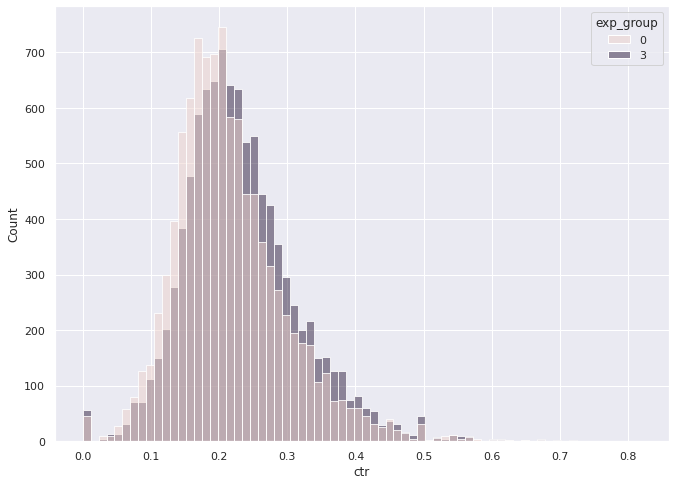

In [41]:
sns.histplot(df_2, x = df_2['ctr'], hue = df_2['exp_group'], alpha = 0.5, bins = 70)

In [45]:
# а вот в этом AB-тесте видим и сохранившуюся 'околонормальность' групп и увеличение показателей по во всех статистиках.

df_2.groupby('exp_group')['ctr'].describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
0,9999.0,0.215950,0.083628,0.0,0.162162,0.202899,0.257143,0.777778
3,10049.0,0.232624,0.086247,0.0,0.176471,0.220339,0.276786,0.818182


In [55]:
df_2['linearazied_likes'] = df_2['likes'] - ctr_control_2 * df_2['views']
df_2.head()

/tmp/ipykernel_115/3950248337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['linearazied_likes'] = df_2['likes'] - ctr_control_2 * df_2['views']


,exp_group,user_id,views,likes,ctr,linearazied_likes
0,3,115383,30,9,0.300000,2.740885
3,3,123580,48,13,0.270833,2.985417
6,0,30319,110,21,0.190909,-1.950087
8,3,118359,38,7,0.184211,-0.928212
10,0,7626,39,14,0.358974,5.863151


In [57]:
# t-test для групп по линаеризированным лайкам
# Здесь видим, что t-test сработал и на обычном ctr, но на лин.лайках pvalue 

cont = df_2[df_2['exp_group'] == 0]['linearazied_likes']
test = df_2[df_2['exp_group'] == 3]['linearazied_likes']
print('Результаты для лин.лайков:', stats.ttest_ind(cont, test, equal_var = False))

cont_simple = df_2[df_2['exp_group'] == 0]['ctr']
test_simple = df_2[df_2['exp_group'] == 3]['ctr']
print('Результаты для обычного ctr:', stats.ttest_ind(cont_simple, test_simple, equal_var = False))

Результаты для лин.лайков: Ttest_indResult(statistic=-15.211973865941879, pvalue=5.747910624133018e-52)
Результаты для обычного ctr: Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)
